# _(Tian, et al., 2020)_ E/I Net for fast response

Implementation of the paper： *Tian, Gengshuo, et al. "Excitation-Inhibition Balanced Neural Networks for Fast Signal Detection." Frontiers in Computational Neuroscience 14 (2020): 79.*

In [1]:
import brainpy as bp
import numpy as np

In [2]:
# set parameters
bp.backend.set('numba')

num = 10000
num_inh = int(num * 0.2)
num_exc = num - num_inh
prob = 0.25

tau_E = 15.
tau_I = 10.
V_reset = 0.
V_threshold = 15.
f_E = 3.
f_I = 2.
mu_f = 0.1

tau_Es = 6.
tau_Is = 5.
JEE = 0.25
JEI = -1.
JIE = 0.4
JII = -1.

In [3]:
# define neuron type


class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, tau, **kwargs):
        self.tau = tau

        self.V = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        super(LIF, self).__init__(size, **kwargs)

    @staticmethod
    @bp.odeint
    def int_f(V, t, tau, Isyn):
        return (-V + Isyn) / tau

    def update(self, _t):
        for i in range(self.num):
            V = self.int_f(self.V[i], _t, self.tau, self.input[i])
            if V >= V_threshold:
                self.spike[i] = 1.
                V = V_reset
            else:
                self.spike[i] = 0.
            self.V[i] = V
            self.input[i] = 0.

In [4]:
# define synapse type

class Syn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay, tau, g_max, **kwargs):
        self.tau = tau
        self.g_max = g_max

        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')

        self.s = bp.ops.zeros(post.num)
        self.g = self.register_constant_delay('g', post.num, delay_time=delay)

        super(Syn, self).__init__(pre, post, **kwargs)

    @staticmethod
    @bp.odeint
    def ints(s, t, tau):
        return - s / tau

    def update(self, _t):
        s = self.ints(self.s, _t, self.tau)
        for pre_i, spike in enumerate(self.pre.spike):
            if spike:
                for post_i in self.pre2post[pre_i]:
                    s[post_i] += 1.
        self.s = s
        self.g.push(self.g_max * s)
        self.post.input += self.g.pull()

In [5]:
# build & simulate network
E_group = LIF(num_exc, tau=tau_E, monitors=['spike'])
E_group.V = np.random.random(num_exc) * (V_threshold - V_reset) + V_reset

I_group = LIF(num_inh, tau=tau_I, monitors=['spike'])
I_group.V = np.random.random(num_inh) * (V_threshold - V_reset) + V_reset

EI_conn = Syn(pre=E_group, post=I_group, conn=bp.connect.FixedProb(prob=prob),
              tau=tau_Es, g_max=JIE, delay=0.)

EE_conn = Syn(pre=E_group, post=E_group, conn=bp.connect.FixedProb(prob=prob),
              tau=tau_Es, g_max=JEE, delay=0.)

II_conn = Syn(pre=I_group, post=I_group, conn=bp.connect.FixedProb(prob=prob),
              tau=tau_Is, g_max=JII, delay=0.)

IE_conn = Syn(pre=I_group, post=E_group, conn=bp.connect.FixedProb(prob=prob),
              tau=tau_Is, g_max=JEI, delay=0.)

net = bp.Network(E_group, I_group, IE_conn, EE_conn, II_conn, EI_conn)
net.run(duration=100.,
        inputs=[(E_group, 'input', f_E * np.sqrt(num) * mu_f),
                (I_group, 'input', f_I * np.sqrt(num) * mu_f)],
        report=True)

Compilation used 5.3124 s.
Start running ...
Run 10.0% used 0.020 s.
Run 20.0% used 0.037 s.
Run 30.0% used 0.057 s.
Run 40.0% used 0.074 s.
Run 50.0% used 0.092 s.
Run 60.0% used 0.110 s.
Run 70.0% used 0.128 s.
Run 80.0% used 0.146 s.
Run 90.0% used 0.164 s.
Run 100.0% used 0.182 s.
Simulation is done in 0.182 s.



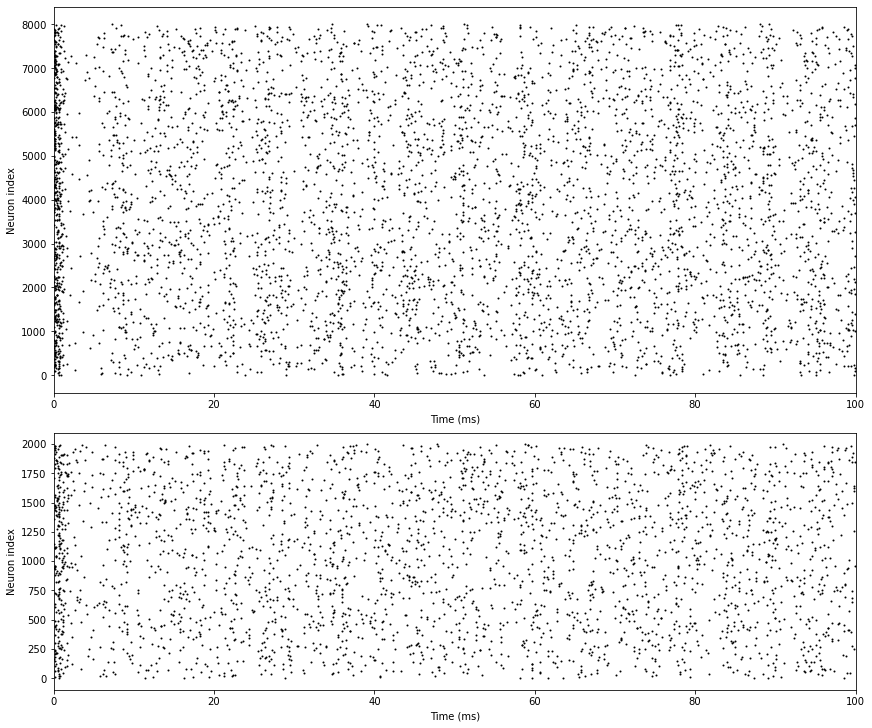

In [6]:
# visualization
fig, gs = bp.visualize.get_figure(5, 1, 2, 12)

bp.visualize.raster_plot(net.ts, E_group.mon.spike,
                         ax=fig.add_subplot(gs[:3, 0]),
                         xlim=(0, 100))

bp.visualize.raster_plot(net.ts, I_group.mon.spike,
                         ax=fig.add_subplot(gs[3:, 0]),
                         xlim=(0, 100),
                         show=True)